 ## מודל לחיזוי לקוחות הפוטנציאליים שיש להם סבירות גבוהה יותר לרכוש הלוואה
 ### הבנקים רוצים להגדיל את הווליאום (לקוחות נכסים) בכדי להכניס יותר הלוואות ולהרוויח יותר באמצעות הריבית על הלוואות.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

from scipy.stats import zscore
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# במערך הנתונים
## הנתונים כוללים מידע דמוגרפי של לקוחות (גיל, הכנסה וכו '), יחסי הלקוח עם הבנק (משכנתא, חשבון ניירות ערך וכו'), ותגובת הלקוח למסע הפרסום האישי האחרון (הלוואה אישית). מבין 5000 הלקוחות הללו, רק 480 (= 9.6%) קיבלו את ההלוואה האישית שהוצעה להם בקמפיין הקודם

In [5]:
data = pd.read_excel('datasets_48024_87370_Bank_Personal_Loan_Modelling.xlsx','Data')
data.columns = ["ID","Age","Experience","Income","ZIPCode","Family","CCAvg","Education","Mortgage","PersonalLoan","SecuritiesAccount","CDAccount","Online","CreditCard"]

In [7]:
data

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [ ]:
data.columns

המשתנים הם כמפורט להלן:

* גיל - גיל הלקוח
* ניסיון - שנות ניסיון
* הכנסה - הכנסה שנתית
* CCAvg - הוצאה ממוצעת בכרטיס אשראי
* משכנתא - ערך משכנתא לבית

משתנים קטגוריים רגילים הם:
* משפחה - גודל המשפחה של הלקוח
* השכלה - רמת השכלה של הלקוח

In [8]:
data.shape

(5000, 14)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5000 non-null   int64  
 1   Age                5000 non-null   int64  
 2   Experience         5000 non-null   int64  
 3   Income             5000 non-null   int64  
 4   ZIPCode            5000 non-null   int64  
 5   Family             5000 non-null   int64  
 6   CCAvg              5000 non-null   float64
 7   Education          5000 non-null   int64  
 8   Mortgage           5000 non-null   int64  
 9   PersonalLoan       5000 non-null   int64  
 10  SecuritiesAccount  5000 non-null   int64  
 11  CDAccount          5000 non-null   int64  
 12  Online             5000 non-null   int64  
 13  CreditCard         5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [10]:
# No columns have null data in the file
data.apply(lambda x : sum(x.isnull()))

ID                   0
Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
dtype: int64

In [11]:
# Eye balling the data
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [12]:
#finding unique data
data.apply(lambda x: len(x.unique()))

ID                   5000
Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
PersonalLoan            2
SecuritiesAccount       2
CDAccount               2
Online                  2
CreditCard              2
dtype: int64

In [14]:
# there are 52 records with negative experience. Before proceeding any further we need to clean the same
data[data['Experience'] < 0]['Experience'].count()

52

In [15]:
#clean the negative variable
dfExp = data.loc[data['Experience'] >0]
negExp = data.Experience < 0
column_name = 'Experience'
mylist = data.loc[negExp]['ID'].tolist() # getting the customer ID who has negative experience

In [16]:
# there are 52 records with negative experience
negExp.value_counts()

False    4948
True       52
Name: Experience, dtype: int64

In [17]:
for id in mylist:
    age = data.loc[np.where(data['ID']==id)]["Age"].tolist()[0]
    education = data.loc[np.where(data['ID']==id)]["Education"].tolist()[0]
    df_filtered = dfExp[(dfExp.Age == age) & (dfExp.Education == education)]
    exp = df_filtered['Experience'].median()
    data.loc[data.loc[np.where(data['ID']==id)].index, 'Experience'] = exp

In [18]:
# checking if there are records with negative experience
data[data['Experience'] < 0]['Experience'].count()

0

In [19]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,4971.0,20.243211,11.359189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


### השפעת הכנסה והשכלה על הלוואה אישית

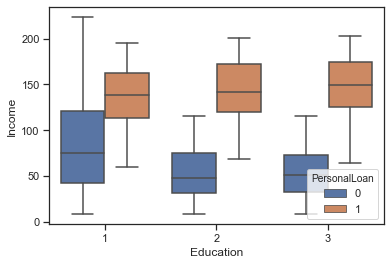

In [20]:
sns.boxplot(x='Education',y='Income',hue='PersonalLoan',data=data)

### תצפית : נראה כי הלקוחות שרמת ההשכלה שלהם היא 1 הם בעלי הכנסה רבה יותר. עם זאת, ללקוחות שלקחו את ההלוואה האישית יש אותן רמות הכנסה

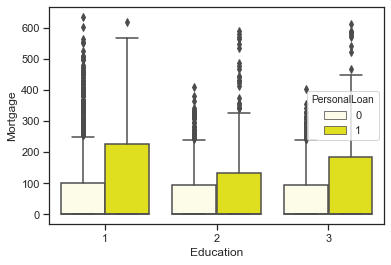

In [21]:
sns.boxplot(x="Education", y='Mortgage', hue="PersonalLoan", data=data,color='yellow')

### הסקה : מהתרשים לעיל נראה שללקוח שאין לו הלוואה אישית ולקוח שיש לו הלוואה אישית יש משכנתא גבוהה

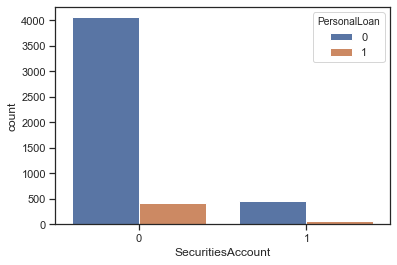

In [22]:
sns.countplot(x="SecuritiesAccount", data=data,hue="PersonalLoan")

### תצפית: לרוב הלקוחות שאין להם הלוואה יש חשבון ניירות ערך

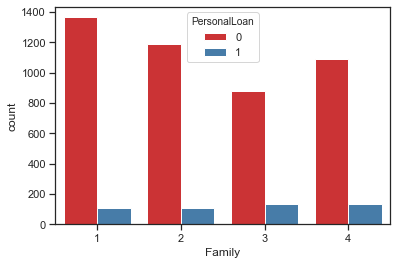

In [23]:
sns.countplot(x='Family',data=data,hue='PersonalLoan',palette='Set1')

### תצפית: לגודל המשפחה אין השפעה על ההלוואות האישיות. אולם נראה כי משפחות עם גודל 3 נוטות יותר הלוואה.

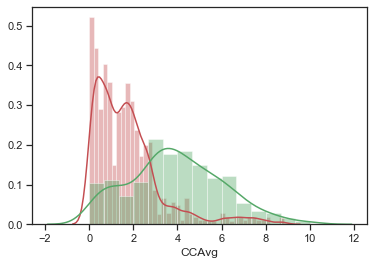

In [25]:
sns.distplot( data[data.PersonalLoan == 0]['CCAvg'], color = 'r')
sns.distplot( data[data.PersonalLoan == 1]['CCAvg'], color = 'g')

In [26]:
print('Credit card spending of Non-Loan customers: ',data[data.PersonalLoan == 0]['CCAvg'].median()*1000)
print('Credit card spending of Loan customers    : ', data[data.PersonalLoan == 1]['CCAvg'].median()*1000)

Credit card spending of Non-Loan customers:  1400.0
Credit card spending of Loan customers    :  3800.0


### תצפית: הגרף מראה שאנשים שיש להם הלוואה אישית יש ממוצע כרטיסי אשראי גבוה יותר. ההוצאה הממוצעת בכרטיס אשראי בחציון של 3800 מצביעה על סיכוי גבוה יותר להלוואות אישיות. פחות הוצאות בכרטיס אשראי עם חציון של 1400 נוטות פחות הלוואה. 

Text(0, 0.5, 'Age')

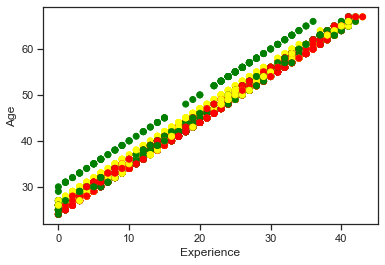

In [27]:
fig, ax = plot.subplots()
colors = {1:'red',2:'yellow',3:'green'}
ax.scatter(data['Experience'],data['Age'],c=data['Education'].apply(lambda x:colors[x]))
plot.xlabel('Experience')
plot.ylabel('Age')

### תצפית: לתצוגת של ניסיון וגיל יש מתאם חיובי. ככל שהניסיון עולה הגיל עולה. גם הצבעים מראים את רמת ההשכלה. יש פער באמצע שנות הארבעים של הגיל וגם יותר אנשים בדרגה לתואר שני

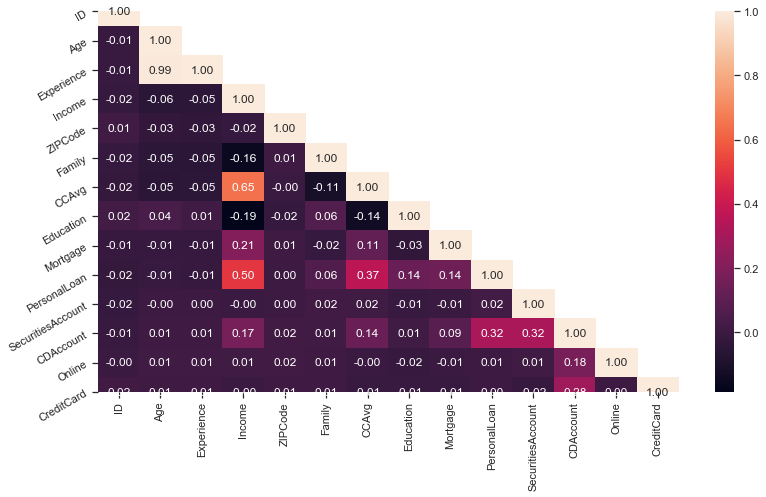

In [28]:
# Correlation with heat map
import matplotlib.pyplot as plt
import seaborn as sns
corr = data.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

### תצפית
* הכנסות ו- CCAvg מתואמות בינוני.
* גיל וניסיון קשורים מאוד

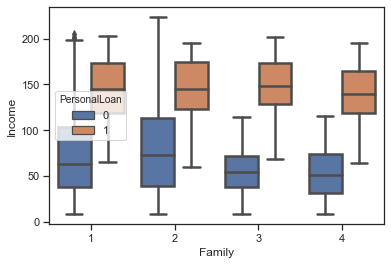

In [29]:
sns.boxplot(x=data.Family,y=data.Income,hue=data.PersonalLoan)
# Looking at the below plot, families with income less than 100K are less likely to take loan,than families with 
# high income

## מודלים לחיזוי
### פיצול נתונים

In [30]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data.drop(['ID','Experience'], axis=1), test_size=0.3 , random_state=100)

In [31]:
train_labels = train_set.pop('PersonalLoan')
test_labels = test_set.pop('PersonalLoan')

### Decision tree classifier

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dt_model=DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
dt_model.fit(train_set, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
dt_model.score(test_set , test_labels)

0.9773333333333334

In [34]:
y_predict = dt_model.predict(test_set)
y_predict[:5]

array([0, 0, 0, 0, 0])

In [35]:
test_set.head(5)

,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
789,29,31,92126,4,0.3,2,0,0,0,1,0
2507,59,60,90048,4,2.1,1,234,0,0,1,1
2376,58,23,91768,3,0.2,1,0,0,0,0,0
1378,54,34,93305,4,0.1,3,0,0,0,1,0
598,56,11,92374,2,0.2,3,90,0,0,0,0


### Naive Bayes

In [36]:
naive_model = GaussianNB()
naive_model.fit(train_set, train_labels)

prediction = naive_model.predict(test_set)
naive_model.score(test_set,test_labels)

0.8866666666666667

### Random Forest classifier

In [37]:
randomforest_model = RandomForestClassifier(max_depth=2, random_state=0)
randomforest_model.fit(train_set, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

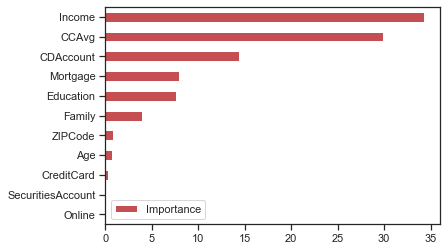

In [38]:
Importance = pd.DataFrame({'Importance':randomforest_model.feature_importances_*100}, index=train_set.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )

In [39]:
predicted_random=randomforest_model.predict(test_set)
randomforest_model.score(test_set,test_labels)

0.904

### KNN ( K - Nearest Neighbour )

In [40]:
train_set_indep = data.drop(['Experience' ,'ID'] , axis = 1).drop(labels= "PersonalLoan" , axis = 1)
train_set_dep = data["PersonalLoan"]
X = np.array(train_set_indep)
Y = np.array(train_set_dep)
X_Train = X[ :3500, :]
X_Test = X[3501: , :]
Y_Train = Y[:3500, ]
Y_Test = Y[3501:, ]

In [41]:
knn = KNeighborsClassifier(n_neighbors= 21 , weights = 'uniform', metric='euclidean')
knn.fit(X_Train, Y_Train)    
predicted = knn.predict(X_Test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y_Test, predicted)
print(acc)

0.9106070713809206


### השוואה בין המודלים

In [42]:
X=data.drop(['PersonalLoan','Experience','ID'],axis=1)
y=data.pop('PersonalLoan')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.898600 (0.008902)
CART: 0.982400 (0.003980)
NB: 0.885600 (0.010385)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.987000 (0.003924)


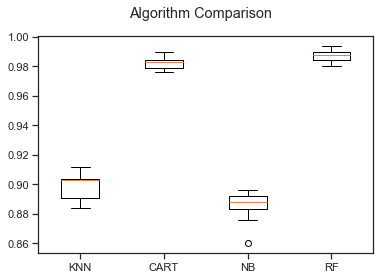

In [43]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=12345)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### סיכום
### מהגרף לעיל נראה שאלגוריתם ** עץ ההחלטה ** הוא בעל רמת הדיוק הגבוהה ביותר ואנחנו יכולים לבחור את זה כמודל הסופי שלנו